# 顔文字生成器（サンプル）
単純ニューラルネットワークだけのシンプル構成  
2次元の系列データに対して転置を行うことで系列をが学習させる

In [1]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=11543c66e2a480e9fcb540700aaeed44917b6917b6cb5142e61d0f71a23f0281
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import japanize_matplotlib
from sklearn.manifold import TSNE

## 前処理

### データ読み込み

In [25]:
# 特殊文字
sp = {'pad': '<PAD>',
      # 'bos': '<BOS>',
      # 'eos': '<EOS>',
      'unk': '<UNK>'}
# pad : padding. 文字列長を一定にするために使う
# bos : begin of sequence. 文頭文字．Decoderの最初の入力
# eos : end of sequence. 文末文字．
# unk : unknown. 出現数が低いものに割り当てる

In [26]:
sp.values()

dict_values(['<PAD>', '<UNK>'])

In [27]:
KAOMOJI_MAX = 10    # 顔文字最大長

kmj_list = []   # 顔文字リスト
len_list = []       # <BOS> から <EOS> までの文字数のリスト
char_list = []      # 顔文字に使用されている文字のリスト

char_list += list(sp.values())
file_name = 'kaomoji_MAX=' + str(KAOMOJI_MAX) + '_DA.txt'

with open(file_name, mode='r') as file:
  for line in file:
    # temp = [sp['bos']]
    temp = list(line.replace('\n', ''))
    # temp += [sp['eos']]
    len_list.append(len(temp))
    temp += [sp['pad'] for _ in range(KAOMOJI_MAX - len(temp))]
    kmj_list.append(temp)
    char_list += temp

# 重複を消す
char_list = sorted(set(char_list), key=char_list.index)

In [28]:
print(kmj_list[0])

['(', '’', '⌒', '’', ')', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [29]:
print('Number of kaomoji  :', len(kmj_list))
print('Number of character:', len(char_list))

Number of kaomoji  : 10300
Number of character: 719


### 出現数が少ないものを置換

In [30]:
# 最小出現数
MIN_APPEAR = 130

kmj_list = np.array(kmj_list)

cnt = 0
for c in char_list:
  mask = (kmj_list == c)
  if np.sum(mask) < MIN_APPEAR:
    kmj_list[mask] = sp['unk']

char_list = list(sp.values()) + kmj_list.flatten().tolist()
char_list = sorted(set(char_list), key=char_list.index)

In [31]:
print('Number of character:', len(char_list))

Number of character: 72


In [32]:
with open('char_list.txt', mode='w') as file:
  for c in char_list:
    file.write(c + '\n')

### 添字検索
顔文字に使われる文字が文字リストの何番目にあるか調べる

In [33]:
kmj_index = []    # 添字リスト

for kmj in kmj_list.tolist():
  temp = [char_list.index(c) for c in kmj]
  kmj_index.append(temp)

In [34]:
print(len_list[0])
kmj_index[0]

5


[2, 1, 3, 1, 4, 0, 0, 0, 0, 0]

### One-hotベクトル化



In [35]:
kmj_num = len(kmj_index)        # 顔文字の総数
kmj_size = len(kmj_index[0])    # 1つの顔文字の長さ
char_num = len(char_list)       # 文字の種類数

# One-hotベクトルリスト
kmj_onehot = np.zeros((kmj_num, kmj_size, char_num))

for i, index in enumerate(kmj_index):
  mask = range(char_num) == np.array(index).reshape((kmj_size, 1))
  kmj_onehot[i][mask] = 1

In [36]:
kmj_onehot.shape

(10300, 10, 72)

### 訓練・検証・テスト用に分ける

In [37]:
dataset = torch.utils.data.TensorDataset(
  torch.tensor(kmj_onehot.astype('float32')),
  torch.tensor(len_list)
)

In [38]:
train_size = int(len(dataset) * 0.85)
valid_size = int(len(dataset) * 0.10)
test_size  = len(dataset) - train_size - valid_size

# indices = np.arange(len(dataset))

# dataset_train = torch.utils.data.Subset(dataset, indices[:train_size])
# dataset_valid = torch.utils.data.Subset(dataset, indices[train_size:train_size+valid_size])
# dataset_test  = torch.utils.data.Subset(dataset, indices[train_size+valid_size:])

split = [train_size, valid_size, test_size]

dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, split)

In [39]:
train_size

8755

In [40]:
batch_size = 256

dataloader_train = torch.utils.data.DataLoader(
  dataset_train,
  batch_size=batch_size,
  shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
  dataset_valid,
  batch_size=batch_size,
  shuffle=True
)

In [41]:
for x, len_seq in dataloader_train:
  print(x.shape, len_seq.shape)
  break

torch.Size([256, 10, 72]) torch.Size([256])


## モデル

### Encoder

In [42]:
class Encoder(nn.Module):
  def __init__(self, N, char_num, emb_dim, hid_dim):
    super().__init__()
    self.W_emb = nn.Parameter(torch.tensor(np.random.uniform(
                   low=-np.sqrt(6 / (char_num + emb_dim)),
                   high=np.sqrt(6 / (char_num + emb_dim)),
                   size=(char_num, emb_dim)
                 ).astype('float32')))

    self.W_1 = nn.Parameter(torch.tensor(np.random.uniform(
                 low=-np.sqrt(6 / (N + hid_dim)),
                 high=np.sqrt(6 / (N + hid_dim)),
                 size=(emb_dim, N, hid_dim)
               ).astype('float32')))
    self.b_1 = nn.Parameter(torch.tensor(np.zeros((emb_dim, 1, hid_dim)).astype('float32')))

    self.W_2 = nn.Parameter(torch.tensor(np.random.uniform(
                 low=-np.sqrt(6 / (emb_dim + 1)),
                 high=np.sqrt(6 / (emb_dim + 1)),
                 size=(hid_dim, emb_dim, 1)
               ).astype('float32')))
    self.b_2 = nn.Parameter(torch.tensor(np.zeros((hid_dim, 1, 1)).astype('float32')))


  def forward(self, x):
    x = torch.matmul(x, self.W_emb)
    # x = F.tanh(x)
    x = (torch.matmul(x.transpose(-2, -1).unsqueeze(-2), self.W_1) + self.b_1).squeeze(-2)
    x = F.tanh(x)
    x = (torch.matmul(x.transpose(-2, -1).unsqueeze(-2), self.W_2) + self.b_2).squeeze(-2)
    x = F.tanh(x)
    return x

In [43]:
encoder = Encoder(10, 137, 8, 32)
x = torch.rand(16, 10, 137)
encoder(x).shape

torch.Size([16, 32, 1])

### Decoder

In [44]:
class Decoder(nn.Module):
  def __init__(self, N, char_num, emb_dim, hid_dim):
    super().__init__()
    # self.W_1 = nn.Parameter(torch.tensor(np.random.uniform(
    #              low=-np.sqrt(6 / (hid_dim + emb_dim)),
    #              high=np.sqrt(6 / (hid_dim + emb_dim)),
    #              size=(hid_dim, emb_dim)
    #            ).astype('float32')))
    # self.b_1 = nn.Parameter(torch.tensor(np.zeros((hid_dim, emb_dim)).astype('float32')))

    self.W_1 = nn.Parameter(torch.tensor(np.random.uniform(
                 low=-np.sqrt(6 / (hid_dim + N)),
                 high=np.sqrt(6 / (hid_dim + N)),
                 size=(N, hid_dim, hid_dim)
               ).astype('float32')))
    self.b_1 = nn.Parameter(torch.tensor(np.zeros((N, 1, hid_dim)).astype('float32')))

    # self.W_2 = nn.Parameter(torch.tensor(np.random.uniform(
    #              low=-np.sqrt(6 / (hid_dim + hid_dim)),
    #              high=np.sqrt(6 / (hid_dim + hid_dim)),
    #              size=(hid_dim, hid_dim)
    #            ).astype('float32')))
    # self.b_2 = nn.Parameter(torch.tensor(np.zeros((1, hid_dim)).astype('float32')))

    self.W_out = nn.Parameter(torch.tensor(np.random.uniform(
                   low=-np.sqrt(6 / (hid_dim + char_num)),
                   high=np.sqrt(6 / (hid_dim + char_num)),
                   size=(hid_dim, char_num)
                 ).astype('float32')))
    self.b_out = nn.Parameter(torch.tensor(np.zeros((N, char_num)).astype('float32')))

  def forward(self, x):
    # x = x * self.W_1 + self.b_1
    x = (torch.matmul(x.transpose(-2, -1).unsqueeze(-2), self.W_1) + self.b_1).squeeze(-2)
    x = F.tanh(x)
    # x = (torch.matmul(x.transpose(-2, -1).unsqueeze(-2), self.W_2) + self.b_2).squeeze(-2)
    # x = torch.matmul(x.transpose(-2, -1), self.W_2) + self.b_2
    # x = F.relu(x)
    x = torch.matmul(x, self.W_out) + self.b_out
    return x

In [45]:
decoder = Decoder(10, 137, 8, 32)
x = torch.rand(16, 32, 1)
decoder(x).shape

torch.Size([16, 10, 137])

### Generator

In [46]:
class Generator(nn.Module):
  def __init__(self, N, char_num, emb_dim, hid_dim):
    super().__init__()
    self.encoder = Encoder(N, char_num, emb_dim, hid_dim)
    self.decoder = Decoder(N, char_num, emb_dim, hid_dim)

  def forward(self, x):
    z = self.encoder(x)
    y = self.decoder(z)
    return y

In [47]:
generator = Generator(10, 137, 8, 32)
x = torch.rand(16, 10, 137)
generator(x).shape

torch.Size([16, 10, 137])

## 学習

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
n_epochs = 100

N = KAOMOJI_MAX
char_num = len(char_list)
emb_dim = 12
hid_dim = 12

net = Generator(N, char_num, emb_dim, hid_dim)

optimizer = optim.Adam(net.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

In [54]:
for epoch in range(n_epochs):
  losses_train = []
  losses_valid = []
  acc_train = 0
  acc_valid = 0

  # 訓練
  net.train()
  for x, len_seq in dataloader_train:
    net.zero_grad()  # 勾配の初期化

    #x.to(device)
    #t.to(device)

    y = net(x)

    loss = criterion(y, x)
    acc_train += (y.argmax(dim=2) == x.argmax(dim=2)).sum()
    loss.backward()  # 誤差の逆伝播
    losses_train.append(loss.tolist())

    optimizer.step()  # パラメータの更新

  # 検証
  net.eval()
  for x, len_seq in dataloader_valid:
    y = net(x)

    loss = criterion(y, x)
    acc_valid += (y.argmax(dim=2) == x.argmax(dim=2)).sum()
    losses_valid.append(loss.tolist())

  if (epoch+1) % 5 == 0:
    print('EPOCH: {:>3}, Train Loss: {:>4.5f}  Acc: {:>.3f},    Valid Loss: {:>4.5f}  Acc: {:>.3f}'.format(
        epoch+1,
        np.mean(losses_train),
        acc_train / (train_size * N),
        np.mean(losses_valid),
        acc_valid / (valid_size * N)
    ))

EPOCH:   5, Train Loss: 0.27018  Acc: 0.295,    Valid Loss: 0.26267  Acc: 0.302
EPOCH:  10, Train Loss: 0.23887  Acc: 0.353,    Valid Loss: 0.23482  Acc: 0.371
EPOCH:  15, Train Loss: 0.20961  Acc: 0.424,    Valid Loss: 0.20214  Acc: 0.438
EPOCH:  20, Train Loss: 0.18790  Acc: 0.460,    Valid Loss: 0.18116  Acc: 0.471
EPOCH:  25, Train Loss: 0.17377  Acc: 0.478,    Valid Loss: 0.16928  Acc: 0.492
EPOCH:  30, Train Loss: 0.16282  Acc: 0.489,    Valid Loss: 0.16380  Acc: 0.503
EPOCH:  35, Train Loss: 0.15380  Acc: 0.499,    Valid Loss: 0.15085  Acc: 0.510
EPOCH:  40, Train Loss: 0.14654  Acc: 0.504,    Valid Loss: 0.14432  Acc: 0.515
EPOCH:  45, Train Loss: 0.14073  Acc: 0.507,    Valid Loss: 0.13635  Acc: 0.517
EPOCH:  50, Train Loss: 0.13590  Acc: 0.509,    Valid Loss: 0.13286  Acc: 0.517
EPOCH:  55, Train Loss: 0.13156  Acc: 0.511,    Valid Loss: 0.12790  Acc: 0.519
EPOCH:  60, Train Loss: 0.12808  Acc: 0.513,    Valid Loss: 0.12756  Acc: 0.523
EPOCH:  65, Train Loss: 0.12497  Acc: 0.

## 評価

In [51]:
def convert_str(x):
  x = np.array(char_list)[x.argmax(dim=1)]
  x = [c for c in x if c not in sp.values()]

  return ''.join(x)

def generate(net, base=None, rate=0.0, mean=0.0, std=1.0):
  if base is None:
    # z = torch.normal(mean=mean, std=std, size=(hid_dim, 1))
    z = torch.tensor(np.random.uniform(low=-1.0, high=1.0, size=(hid_dim, 1)).astype('float32'))
    # print(z)
  else:
    z = net.encoder(base.unsqueeze(0))
    eps = 2 * rate * torch.rand(hid_dim, 1) - rate
    z = z + eps

  y = net.decoder(z)
  gen = convert_str(y.squeeze(0))

  return ''.join(gen)

### 次元圧縮テスト
目標はbaseとgenerateで全く同じもの．
次元圧縮して，潜在ベクトルが獲得できているかどうかのテスト．

In [52]:
for i in np.random.randint(0, len(dataset_test), size=10):
  test = dataset_test[i][0]
  print('base     :', convert_str(test))
  print('generate :', generate(net, base=test, rate=0.0))

base     : (-:|>
generate : (́o`))♪♪
base     : (;　'　'　)"
generate : (*　́ω`*`♪
base     : σ(　̄。　̄)
generate : ヾ(　́ω　́)
base     : ~~~~(・_・)
generate : ♪~ヾヾ(́ω`)ノ
base     : ♪(/́　∇\)
generate : σ́ó　ゝ-*)
base     : (ノ∇≦*)
generate : (/ώ*)♪♪
base     : (_-　)
generate : (∇́　)♪♪♪
base     : o((>□□<))
generate : ヽ(``ω∇`)ノ
base     : ♪♪(*^□^*)
generate : ♪ヾ(*́∇`　)
base     : (/⌒▽)/
generate : (　́Д`ゞ♪


### 生成テスト
潜在ベクトルに乱数を入力しその出力を見る．

In [ ]:
# z_list = net.encoder(dataset_train[:][0])
# mean = float(torch.mean(z_list))
# std = float(torch.mean(torch.std(z_list, dim=1)))
# print('mean :{:.5f}   std : {:.5f}'.format(mean, std))
for _ in range(100):
  print('generate :', generate(net, base=None, mean=0.0, std=0.33))

generate : \>́o^　<
generate : ♪́-ゞ;-́́●)
generate : `。`　_(ー`)
generate : "́　(*　́=)
generate : ヽ(`σ・`*
generate : ♪/(́`)-<。
generate : (́　≧)ゝ　ゝ
generate : (*σ́Д́;)o
generate : ー　ノ_ó♪♪　
generate : ♪ヽ`ωゝ^≧　　)
generate : ◇~́σ(　́)
generate : (●　́́∀`☆♪
generate : ヾ(;　́∀)
generate : (/ヽ　、Д・<　ゝ
generate : >。`ノ∀`́ヽノ
generate : ☆ヽ;́-)ノ)-
generate : ♪́́(́́́σ)
generate : ♪/　́　)ノ-
generate : ・♪;_``)-。
generate : "́　　)ゝ;ヽ.-
generate : (Дó;ω_ゝ)
generate : (☆`☆　́<　・
generate : ーДノ_　́)♪
generate : 　。ゝ`)ゝ)♪_
generate : (≧◇́∀`)ゞ
generate : (;。;∀≦́)ゝ
generate : ヾノゝ́∀́;♪
generate : (ヾ　oω.<́　o
generate : ♪・Дゝ́。Д)　
generate : ♪　　́`o))
generate : ♪́Д̄)ノ<`ヽ
generate : <Д　(、ノ_♪́>
generate : ́)ゝ)-;*
generate : ♪()-́Д́)/
generate : ー_♪́σ-、♪
generate : (-v́/♪́　
generate : ゝ　́o∀`))ゝ。
generate : ~́Д(●♪　́^
generate : ♪　♪o-́)ノ)
generate : _　v　♪)-
generate : ヾ　ゝ)-́<)　)
generate : ~　(`^́;)ノ
generate : ♪　-́óó
generate : ヾ(。_óД)　)
generate : ●　́o)́☆~
generate : 　!ゝ　)-
generate : !(☆́-)́`))
generate : ヽ(　>∇`)/
generat

### 類似度テスト
訓練データの中から潜在ベクトルの距離が近いものを見る．

In [ ]:
def similar(net, base, num=10):
  z = net.encoder(base.unsqueeze(0))

  size = list(z.shape)
  size[0] = 0
  z_list = torch.empty(size, dtype=torch.float)
  z_list = net.encoder(dataset_train[:][0])

  diff = z_list - z
  norm = enumerate(torch.norm(diff.reshape(-1, hid_dim), dim=1))
  norm = sorted(norm, key=lambda x: x[1])

  for i in range(num):
    min_index = norm[i][0]
    str = convert_str(dataset_train[min_index][0])
    print('{} : {}'.format(str, norm[i][1]))

In [ ]:
i = np.random.randint(0, len(dataset_test))
test = dataset_test[i][0]
print(convert_str(test), ' : base')
similar(net, test, num=10)

(・_ゞ)...  : base
(Tーヾ)... : 0.884737491607666
(⌒-⌒)... : 1.5414663553237915
(ω)... : 1.5762689113616943
(・_☆)!! : 1.5819783210754395
(°°)ーー : 1.7329403162002563
(_) : 1.745798110961914
(▼ω▼)ーー : 1.7708499431610107
(・□ゞ... : 1.7919739484786987
(・・*)ノ⌒ : 1.7930209636688232
(^^)... : 1.8052200078964233


### 潜在ベクトルの分布図
t-SNEという次元削減アルゴリズムがあるらしいので，それを使って潜在ベクトルを2次元化して表示

In [ ]:
z_list = net.encoder(dataset_train[:][0]).squeeze(-1).detach().numpy()
z_reduc = TSNE(n_components=2).fit_transform(z_list).T

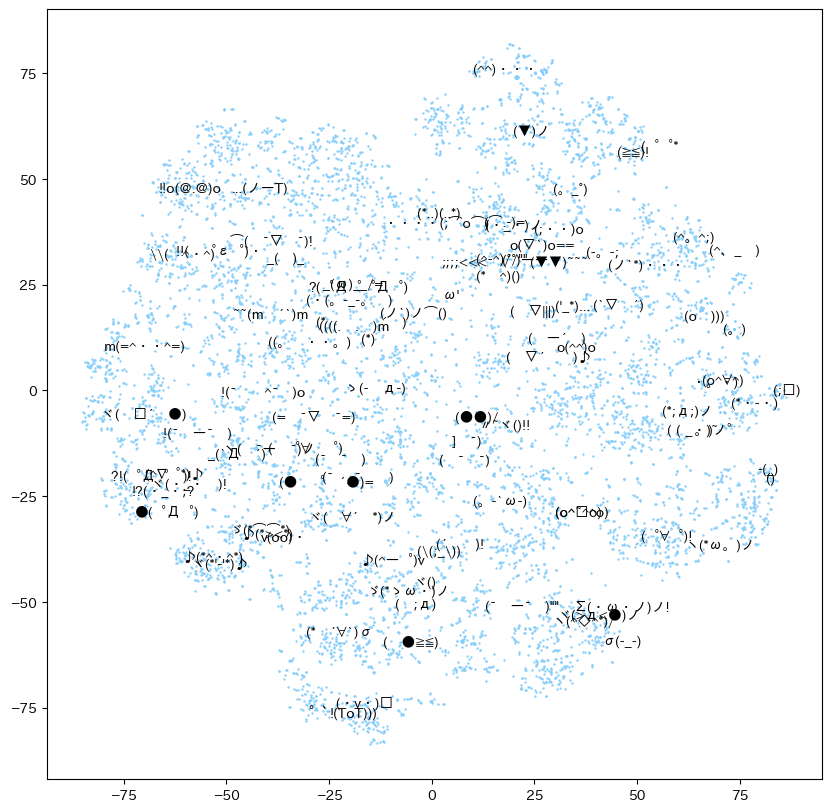

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(*z_reduc, s=0.5, c='lightskyblue')

for i in random.sample(range(len(dataset_train)), 100):
  plt.text(*z_reduc[:, i], convert_str(dataset_train[i][0]), fontsize=10)

plt.show()

### 潜在ベクトルのヒストグラム

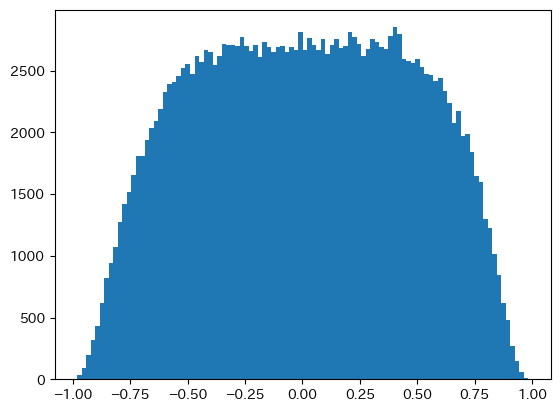

In [ ]:
z_flat = net.encoder(dataset_train[:][0]).detach().numpy().flatten()
c, l, p = plt.hist(z_flat, bins=100)

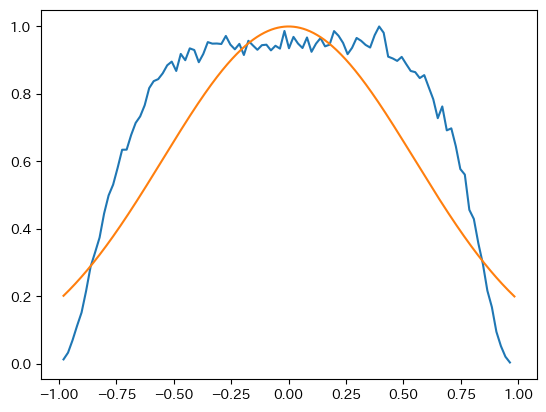

In [ ]:
plt.plot(l[:-1], c / c.max())

n = 1000
x = np.linspace(z_flat.min(), z_flat.max(), n)
y = np.exp(- (x - 0.0)**2 / (2 * 0.3))
plt.plot(x, y)

plt.show()

## モデルの保存

In [ ]:
torch.save(net.state_dict(), 'complin_params.pth')

In [ ]:
# モデルのロードテスト
model = Generator(N, char_num, emb_dim, hid_dim)
model.load_state_dict(torch.load('complin_params.pth'))

model.eval()

Generator(
  (encoder): Encoder()
  (decoder): Decoder()
)

In [ ]:
# 次元圧縮テスト
for i in np.random.randint(0, len(dataset_test), size=10):
  test = dataset_test[i][0]
  print('base     :', convert_str(test))
  print('generate :', generate(model, base=test, rate=0.0))

base     : (゚∀゚)!
generate : (≧∇`)♪
base     : o(>ωω<)o
generate : ヾ(ゝ∇Д-)ノ
base     : ヽ(`⌒　́)ノ
generate : ヽ(`́　́)ノ
base     : (。・・!!☆
generate : (*・`))♪
base     : (-_-)
generate : (́Д-)♪♪
base     : (-ω-)ノ
generate : (́Д-)ノ
base     : (。・ω・。)
generate : (*́ω゚`)
base     : (　;);́　)
generate : (　`);́　)
base     : σ(ε;)
generate : ヽ(Д;)
base     : (-□。□)
generate : (-∇　、)


In [ ]:
# 生成テスト
for _ in range(10):
  print('generate :', generate(model, base=None, mean=0.0, std=0.33))

generate : 　~ヽ́;ゞσ́>。
generate : ́。.`♪́́ゞ\)
generate : -　Д́♪)♪ー∇)
generate : ゝ́。\♪ヾ>);^
generate : ~　()>Д<́*ゞ
generate : (・Д́　●)♪
generate : (ー♪)　́♪́
generate : (("`)♪ー∇`<
generate : 　)。дo(<))
generate : 。́。)^́(☆


## 感想

このネットワークは，  
Encoder：Embedding+T+MLP+T+MLP  
Decoder：T+MLP+T+Linear  
の構成

転置を繰り返し、文字ベクトル方向と系列方向の両方で学習させる．
このときに，行ベクトル毎に異なる重みで計算させる．
計算の度に次元を変え，潜在ベクトルは1次元となる

層を減らし，間にtanhを入れた．これにより，潜在ベクトルを-1から1に留め，ランダム生成がしやすくなることに期待する．  
また，FPGA実装を想定し，emb_dimとhid_dimを揃えた．